# Import Librairie

In [75]:
from ModuleFinance import *

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import datetime as dt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import os

In [79]:
Udl = MarketData(Spot=100, Vol=load_surface("Data/Démonstration/Vol.json"), Taux=load_curve("Data/Démonstration/Taux.json"), Div=load_curve("Data/Démonstration/Div.json"))
Produit = Autocall(MarketData=Udl, Coupon= 0.1, B_Recall=100, B_Coupon=100, B_PDI=80, K=100, Obs=12, T=1)
MC = MonteCarlo(Udl,2,252,250_00)

c:\Users\cleme\OneDrive\Bureau\3. Mémoire\ModuleFinance\finfunc.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._spline_equation = np.array([np.array(CubicSpline(pd.DataFrame(self.loc[mat, :])).calculate_spline_coefficients()) for mat in self.index])


# VI Interpolation

In [83]:
Udl.Vol = Udl.Vol.loc[:1095]

c:\Users\cleme\OneDrive\Bureau\3. Mémoire\ModuleFinance\finfunc.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._spline_equation = np.array([np.array(CubicSpline(pd.DataFrame(self.loc[mat, :])).calculate_spline_coefficients()) for mat in self.index])


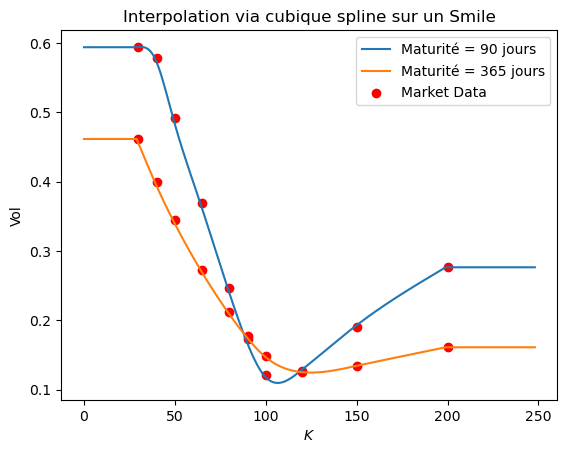

In [81]:
#check spline interpolation:
Maturité = 90
rlst = []
rlst2 = []
for j in range(1,250):
	rlst.append(Udl.get_vol(Maturité, j))
	rlst2.append(Udl.get_vol(365, j))
plt.plot(rlst, label="Maturité = 90 jours")
plt.plot(rlst2, label="Maturité = 365 jours")
plt.scatter(Udl.Vol.columns, Udl.Vol.loc[Maturité,:], marker="o", color="red", label="Market Data")
plt.scatter(Udl.Vol.columns, Udl.Vol.loc[365,:], marker="o", color="red")
plt.xlabel("$K$")
plt.ylabel("Vol")
plt.title("Interpolation via cubique spline sur un Smile")
plt.legend()
plt.show()

In [86]:
print(Udl.get_vol(90, 30))
print(Udl.get_vol(90, 31))

0.59366431
0.5939419849931695


In [88]:
print(CallOption(Udl, 30, 90).price())
print(CallOption(Udl, 31, 90).price())
CallOption(Udl, 30, 90).price() - CallOption(Udl, 31, 90).price()

0.0010431469232207564
0.0010429399508899064


2.069723308499409e-07

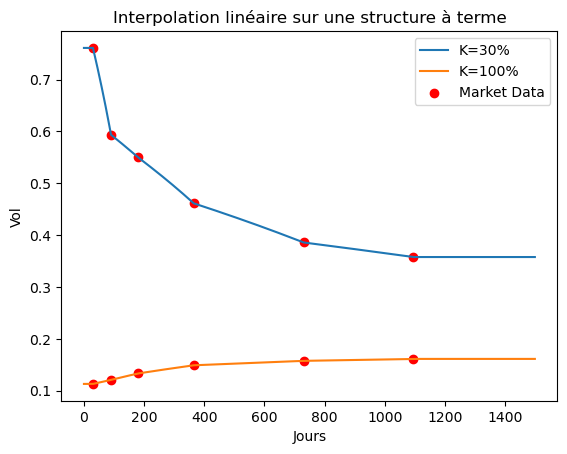

In [84]:
#check linéaire interpolation
Strike = 100
rslt = []
rslt2 = []
for j in range(0,1500):
	rslt.append(Udl.get_vol(j, Strike))
	rslt2.append(Udl.get_vol(j, 30))
plt.plot(rslt2, label="K=30%")
plt.plot(rslt, label="K=100%")
plt.scatter(Udl.Vol.index, Udl.Vol.loc[:,Strike], marker="o", color="red", label="Market Data")
plt.scatter(Udl.Vol.index, Udl.Vol.loc[:,30], marker="o", color="red")
plt.xlabel("Jours")
plt.ylabel("Vol")
plt.title("Interpolation linéaire sur une structure à terme")
plt.legend()
plt.show()


In [91]:
import plotly.graph_objects as go
# Create the surface plot
fig = go.Figure(data=[go.Surface(z=Udl.Vol.values, y=Udl.Vol.index, x=Udl.Vol.columns)])

# Update the layout to include axis labels
fig.update_layout(
    scene=dict(
        xaxis_title='K',
        yaxis_title='Jours',
        zaxis_title='Vol'
    )
)

# Show the plot
fig.show()

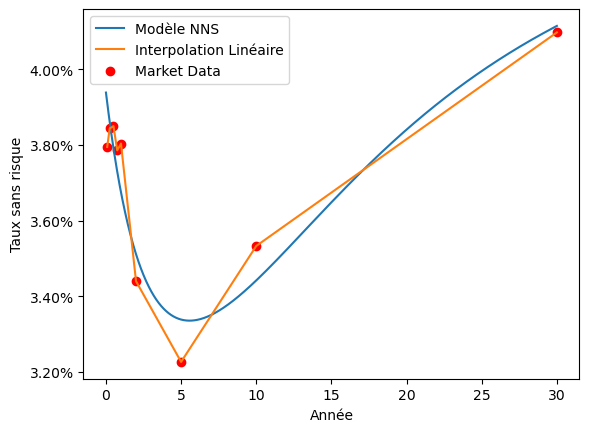

In [94]:
x = np.linspace(0.000001,30,252*30)
plt.plot(x, Udl.get_rate(x), label="Modèle NNS")
plt.plot(Udl.Taux[0], Udl.Taux[1], label = "Interpolation Linéaire")
plt.xlabel("Année")
plt.ylabel("Taux sans risque")
plt.scatter(Udl.Taux[0], Udl.Taux[1], marker="o", color="red", label="Market Data")
def percent_fmt(x, pos):
    return f'{x*100:.2f}%'

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(percent_fmt))
plt.legend()
plt.show()

# Simu de Monte-Carlo

In [149]:
kappa = 3  			    #vitesse de retour à la moyenne
theta = 0.16**2     #moyenne
v0 = 0.25**2        #variance_ini  
sigma = 0.6			    #vol de vol
rho = -0.8

c:\Users\cleme\OneDrive\Bureau\3. Mémoire\ModuleFinance\finfunc.py:12: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



In [150]:
%timeit MC.vol_standard()
%timeit MC.vol_local()
%timeit MC.vol_sto(rho,v0,kappa,theta,sigma)

232 ms ± 53.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
353 ms ± 68.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
355 ms ± 78.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Black-Scholes

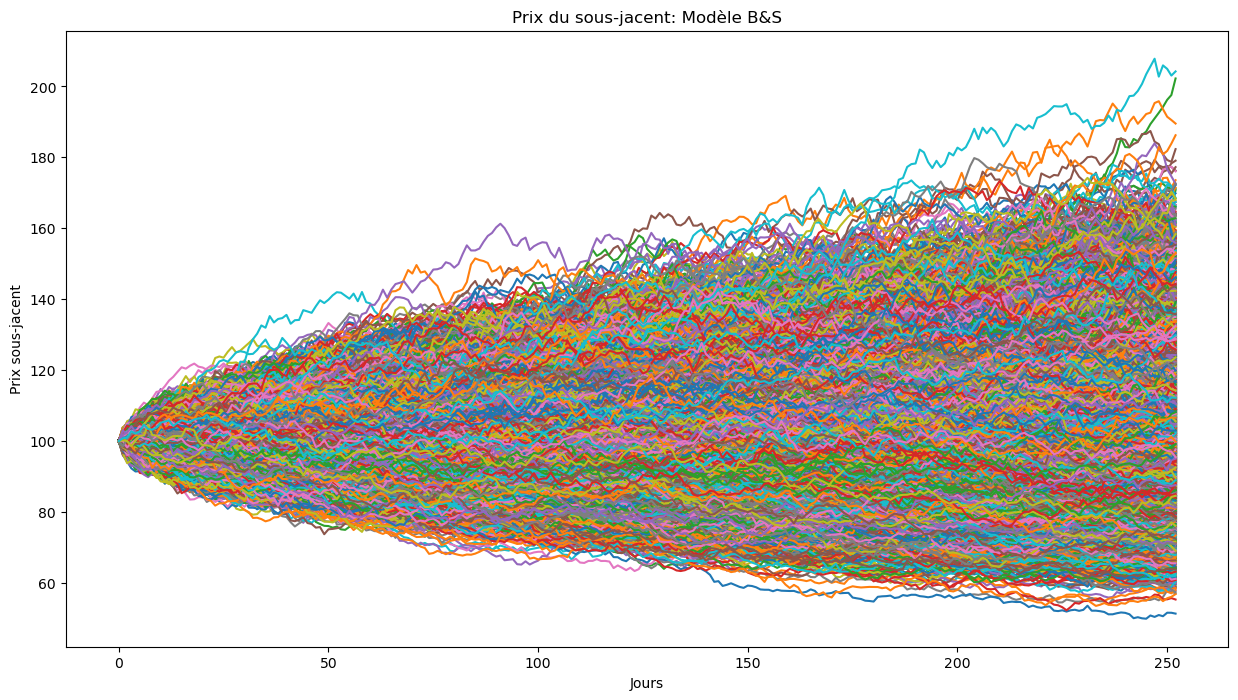

In [13]:
df_bs = MC.vol_standard()
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df_bs.T)
plt.title("Prix du sous-jacent: Modèle B&S")
plt.xlabel("Jours")
plt.ylabel("Prix sous-jacent")
plt.show()

## Vol Locale

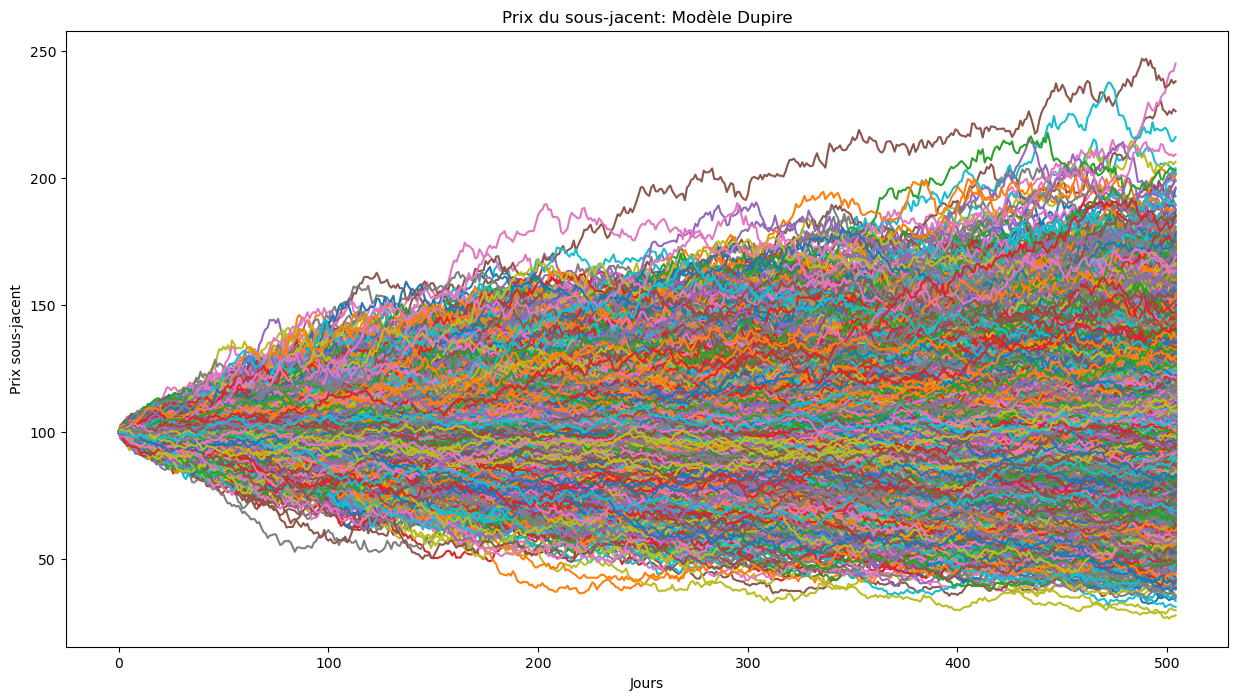

In [172]:
df_lc = MC.vol_local()
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df_lc.T)
plt.title("Prix du sous-jacent: Modèle Dupire")
plt.xlabel("Jours")
plt.ylabel("Prix sous-jacent")
plt.show()

## Vol Sto

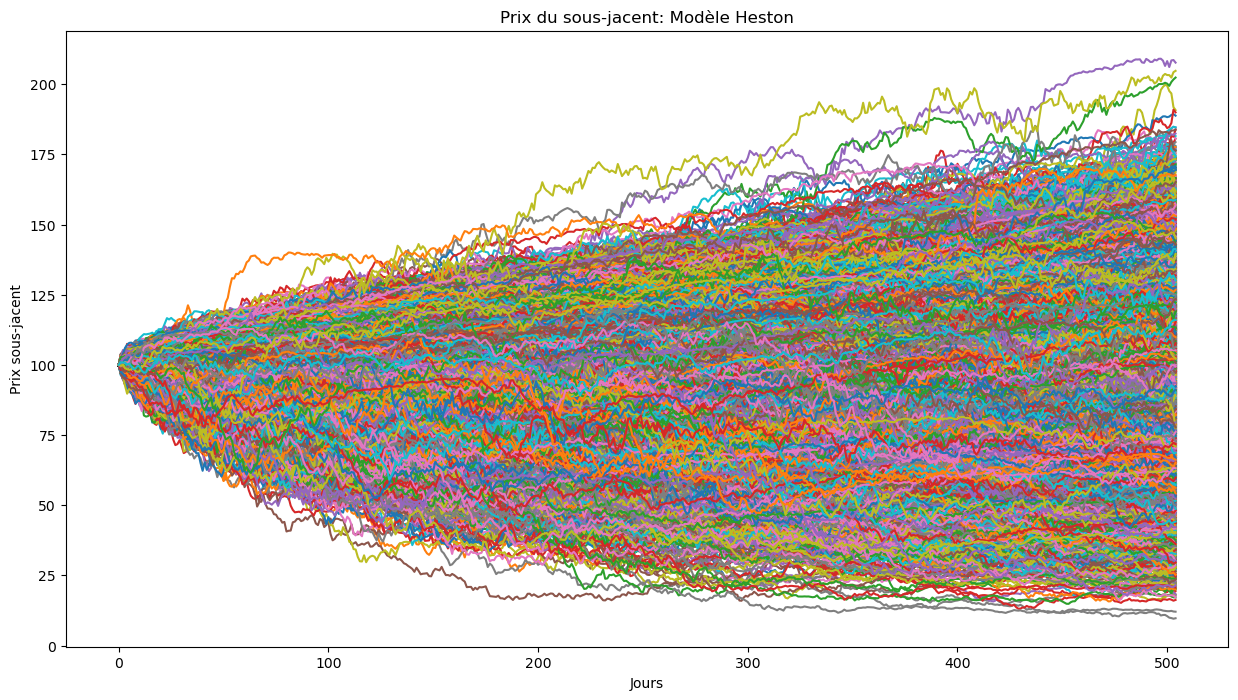

In [9]:
param = {"Correl":-0.8,"Variance":0.15**2,"Kappa":3, "Theta":0.2**2, "vol_vol":0.5}
df_sto = MC.vol_sto(**param)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df_sto.T)
plt.title("Prix du sous-jacent: Modèle Heston")
plt.xlabel("Jours")
plt.ylabel("Prix sous-jacent")
plt.show()

c:\Users\cleme\OneDrive\Bureau\3. Mémoire\ModuleFinance\finfunc.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._spline_equation = np.array([np.array(CubicSpline(pd.DataFrame(self.loc[mat, :])).calculate_spline_coefficients()) for mat in self.index])


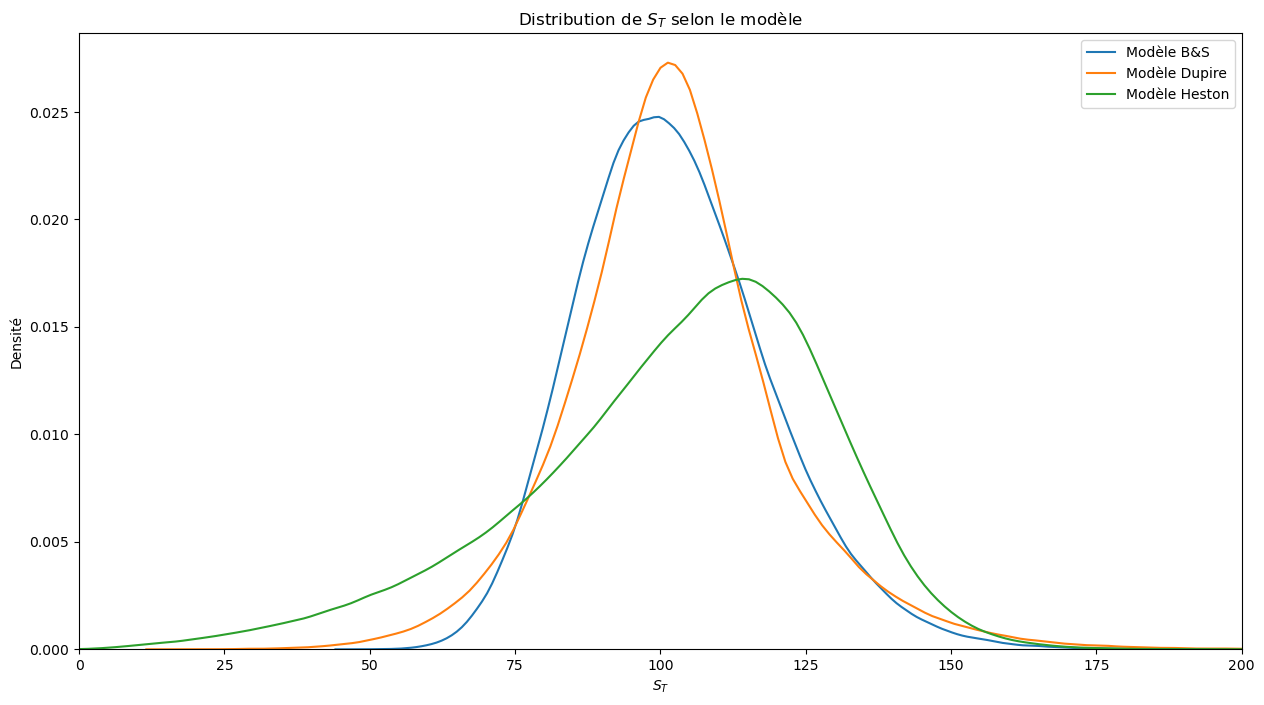

In [156]:
Udl = MarketData(Spot=100, Vol=load_surface("Data/Démonstration/Vol.json"), Taux=load_curve("Data/Démonstration/Taux.json"), Div=load_curve("Data/270624/Div.json"))
MC = MonteCarlo(Udl,2,252,500_000)

df_bs = MC.vol_standard()
df_lc = MC.vol_local()
df_sto = MC.vol_sto(**{"Correl":-0.8,"Variance":0.15**2,"Kappa": 3, "Theta":0.2**2, "vol_vol":1.0})

fig, ax = plt.subplots(figsize=(15,8))
ax = sns.kdeplot(df_bs.T[-1], label="Modèle B&S", ax=ax)
ax = sns.kdeplot(df_lc.T[-1], label="Modèle Dupire", ax=ax)
ax = sns.kdeplot(df_sto.T[-1], label="Modèle Heston", ax=ax)
plt.xlim([0, 200])
plt.xlabel('$S_T$')
plt.ylabel('Densité')
plt.title("Distribution de $S_T$ selon le modèle")
plt.legend()
plt.show()

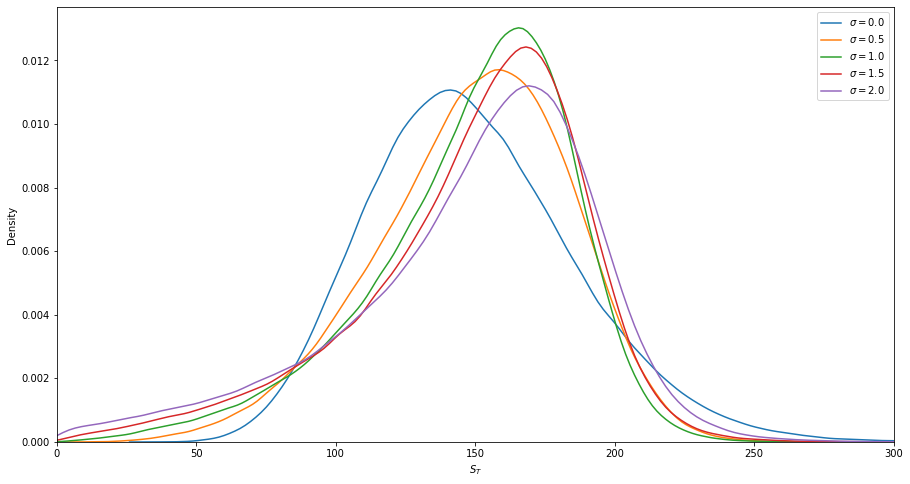

In [7]:
#Vol de Vol Analyse
df_sto0 = MC.vol_sto(Correl=-0.8, Variance=v0, Kappa=kappa, Theta = theta, vol_vol=0.1)
df_sto1 = MC.vol_sto(Correl=-0.8, Variance=v0, Kappa=kappa, Theta = theta, vol_vol=0.5)
df_sto2 = MC.vol_sto(Correl=-0.8, Variance=v0, Kappa=kappa, Theta = theta, vol_vol=1)
df_sto3 = MC.vol_sto(Correl=-0.8, Variance=v0, Kappa=kappa, Theta = theta, vol_vol=1.5)
df_sto4 = MC.vol_sto(Correl=-0.8, Variance=v0, Kappa=kappa, Theta = theta, vol_vol=2)

fig, ax = plt.subplots(figsize=(15,8))
ax = sns.kdeplot(df_sto0.T[504], label=r"$\sigma = 0.0$", ax=ax)
ax = sns.kdeplot(df_sto1.T[504], label=r"$\sigma = 0.5$", ax=ax)
ax = sns.kdeplot(df_sto2.T[504], label=r"$\sigma = 1.0$", ax=ax)
ax = sns.kdeplot(df_sto3.T[504], label=r"$\sigma = 1.5$", ax=ax)
ax = sns.kdeplot(df_sto4.T[504], label=r"$\sigma = 2.0$", ax=ax)
plt.xlim([0, 300])
plt.xlabel('$S_T$')
plt.ylabel('Density')
plt.legend()
plt.show()

# Price MC

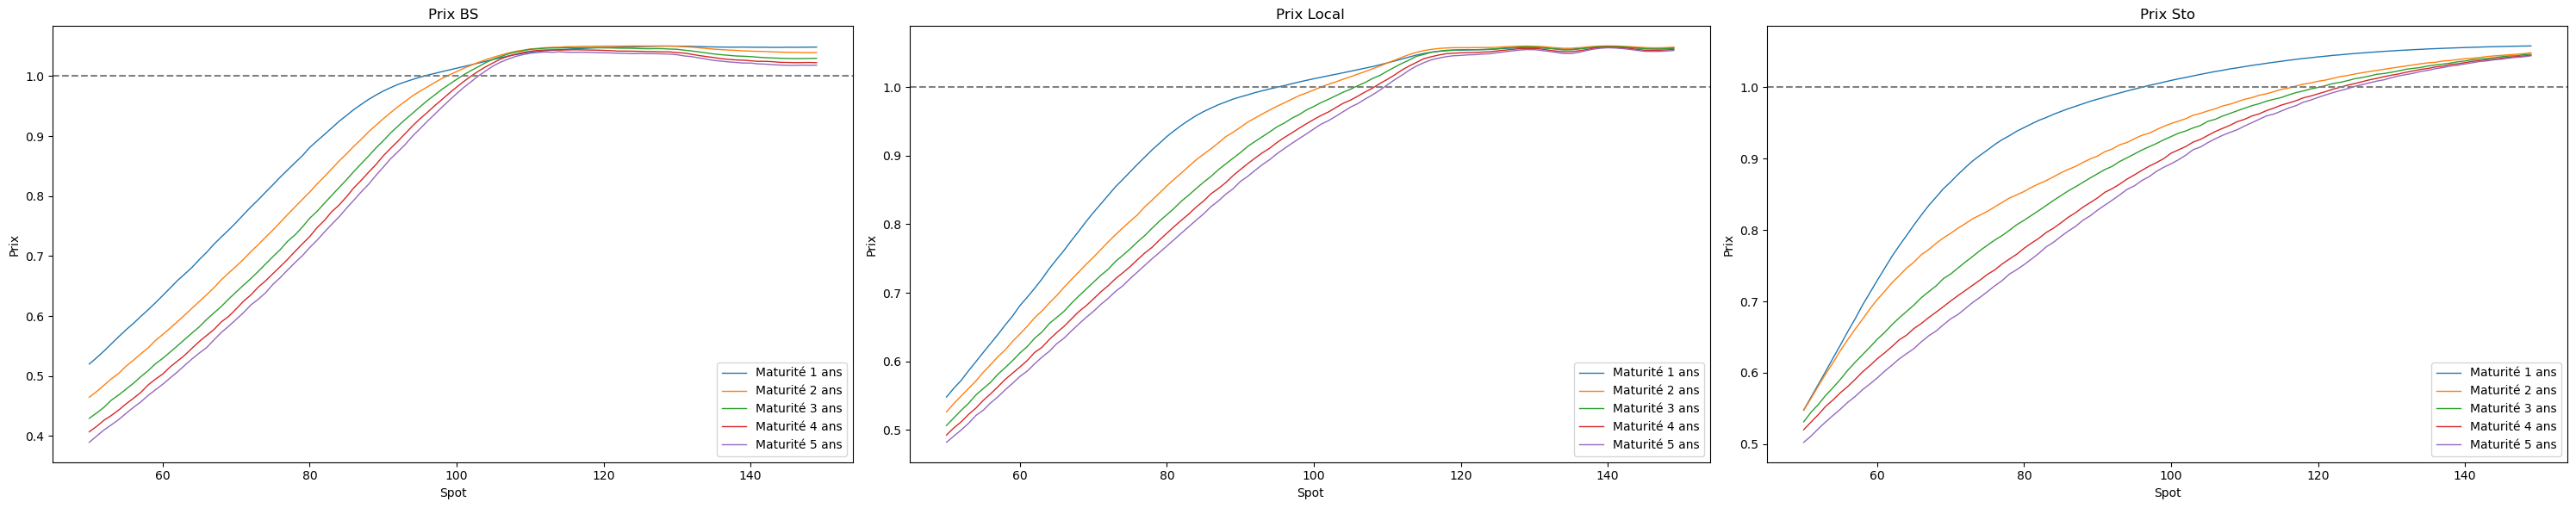

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(30, 6))

# Plot Prix BS
for t in range(1, 6):
    Prix = []
    Produit = Autocall(MarketData=Udl, Coupon= 0.1, B_Recall=110, B_Coupon=100, B_PDI=60, K=100, Obs=12, T=t)
    for i in range(50,150):
        Udl.Spot = i
        Prix.append(Produit.price())
    axs[0].plot(range(50, 150), Prix, linewidth=1, label=f"Maturité {round(t, 0)} ans")
axs[0].set_title("Prix BS")

# Plot Prix Local
for t in range(1, 6):
    Prix = []
    Produit_local = Autocall(MarketData=Udl, Coupon= 0.1, B_Recall=110, B_Coupon=100, B_PDI=60, K=100, Obs=12, T=t, vol_model="vol_local")
    for i in range(50,150):
        Udl.Spot = i
        Prix.append(Produit_local.price())
    axs[1].plot(range(50, 150), Prix, linewidth=1, label=f"Maturité {round(t, 0)} ans")
axs[1].set_title("Prix Local")

# Plot Prix Sto
for t in range(1, 6):
    Prix = []
    Produit_sto = Autocall(MarketData=Udl, Coupon= 0.1, B_Recall=110, B_Coupon=100, B_PDI=60, K=100, Obs=12, T=t, vol_model="vol_sto")
    for i in range(50,150):
        Udl.Spot = i
        Prix.append(Produit_sto.price(Correl=-0.7,Variance=0.2**2, Kappa= 3, Theta=0.15**2, vol_vol=1.5))
    axs[2].plot(range(50, 150), Prix, linewidth=1, label=f"Maturité {round(t, 0)} ans")
axs[2].set_title("Prix Sto")

for ax in axs:
    ax.axhline(y=1, color="gray", linestyle="--")
    ax.set_xlabel("Spot")
    ax.set_ylabel("Prix")
    ax.legend()

plt.tight_layout()
plt.show()

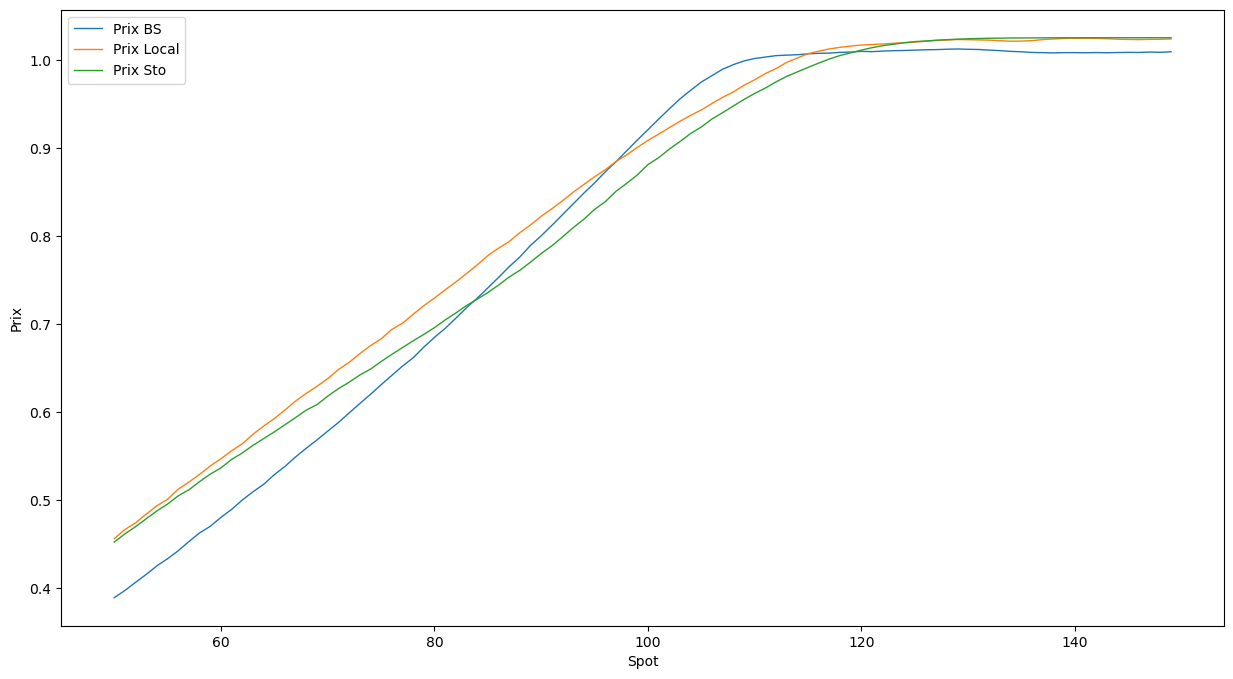

In [140]:
#Prix
Prix_BS, Prix_Local, Prix_Sto = [],[],[]
fig, ax = plt.subplots(figsize=(15,8))
Produit_bs = Autocall(MarketData=Udl, Coupon= 0.1, B_Recall=110, B_Coupon=100, B_PDI=80, K=100, Obs=6, T=5)
Produit_local = Autocall(MarketData=Udl, Coupon= 0.1, B_Recall=110, B_Coupon=100, B_PDI=80, K=100, Obs=6, T=5, vol_model="vol_local")
Produit_sto = Autocall(MarketData=Udl, Coupon= 0.1, B_Recall=110, B_Coupon=100, B_PDI=80, K=100, Obs=6, T=5, vol_model="vol_sto")
for i in range(50,150):
    Udl.Spot = i
    Prix_BS.append(Produit_bs.price())
    Prix_Local.append(Produit_local.price())
    Prix_Sto.append(Produit_sto.price(Correl=-0.8,Variance=0.1**2,Kappa= 3, Theta=0.2**2, vol_vol=1.5))
ax.plot(range(50,150), Prix_BS, linewidth=1, label=f"Prix BS")
ax.plot(range(50,150), Prix_Local, linewidth=1, label=f"Prix Local")
ax.plot(range(50,150), Prix_Sto, linewidth=1, label=f"Prix Sto")
ax.legend()
plt.xlabel("Spot")
plt.ylabel("Prix")
plt.show()